### Import

In [1]:
import glob
from datetime import date, datetime, timedelta
#from cartopy.crs import NorthPolarStereo, LambertAzimuthalEqualArea
#import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.image
from netCDF4 import Dataset
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import pearsonr
from scipy.signal import correlate2d
#import xarray as xr
import sklearn.metrics as skm
from PIL import Image

### Importe and structure data

In [2]:
start_date = date(2023, 1, 1)
end_date = date(2023, 5, 30)
path_data = '/home/malela/data/nic_nersc_stats/*'

data_p = np.array(())
day_p = []

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

for single_date in daterange(start_date, end_date):
    #print(single_date.strftime("%Y-%m-%d"))
    day = single_date.strftime("%d")
    month = single_date.strftime("%m")
    year = single_date.strftime("%Y")

    #stat_txt = sorted(glob.glob(path_data + month + day +'.txt'))
    stat_txt = sorted(glob.glob('/home/malela/data/nic_nersc_stats/us_stats_23'+month+day+'.txt'))
    #print(stat_txt)
    
    if len(stat_txt) > 0:
    
        data_day = []
        with open(stat_txt[0], "r") as file:
                lines = file.readlines()

        # single number
        for i in range (0, 7):
            line = np.array(lines[i]).astype('float32')
            data_day.append(line)

        for j in range (20, 25):
            line = np.array(lines[j]).astype('float32')
            data_day.append(line)

        # lists
        for k in range (7, 11):
            line = np.array(lines[k].split(';')).astype('float32')
            data_day.append(line)

        for h in range (16, 20):
            line = np.array(lines[h].split(';')).astype('float32')
            data_day.append(line)

        # matrix
        cf = np.empty((0, 4))
        for g in range (12,16):
            row = np.array(lines[g].split(';')).astype('float32')
            cf = np.vstack((cf, row))
        data_day.append(cf)

        data_p = np.append(data_p, data_day)
        day_p.append(year +' - '+ month +' - '+ day)

print(data_p.shape)

(189,)


/home/malela/miniconda3/envs/CNN/lib/python3.10/site-packages/numpy/core/fromnumeric.py:1859: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


In [3]:
matrix = np.array(data_p[::21].tolist())

for i in range (1, 12):
    matrix = np.vstack((matrix, data_p[i::21].tolist()))

for j in range (12, 20):
    for k in range (len(data_p[j::25][0])):
        metric = [liste[k] for liste in data_p[j::21]]
        matrix = np.vstack((matrix, metric))

print(matrix.shape)
        
cf = np.corrcoef(matrix)

(47, 9)


### Display data

matrix of correlation of every metrics computed

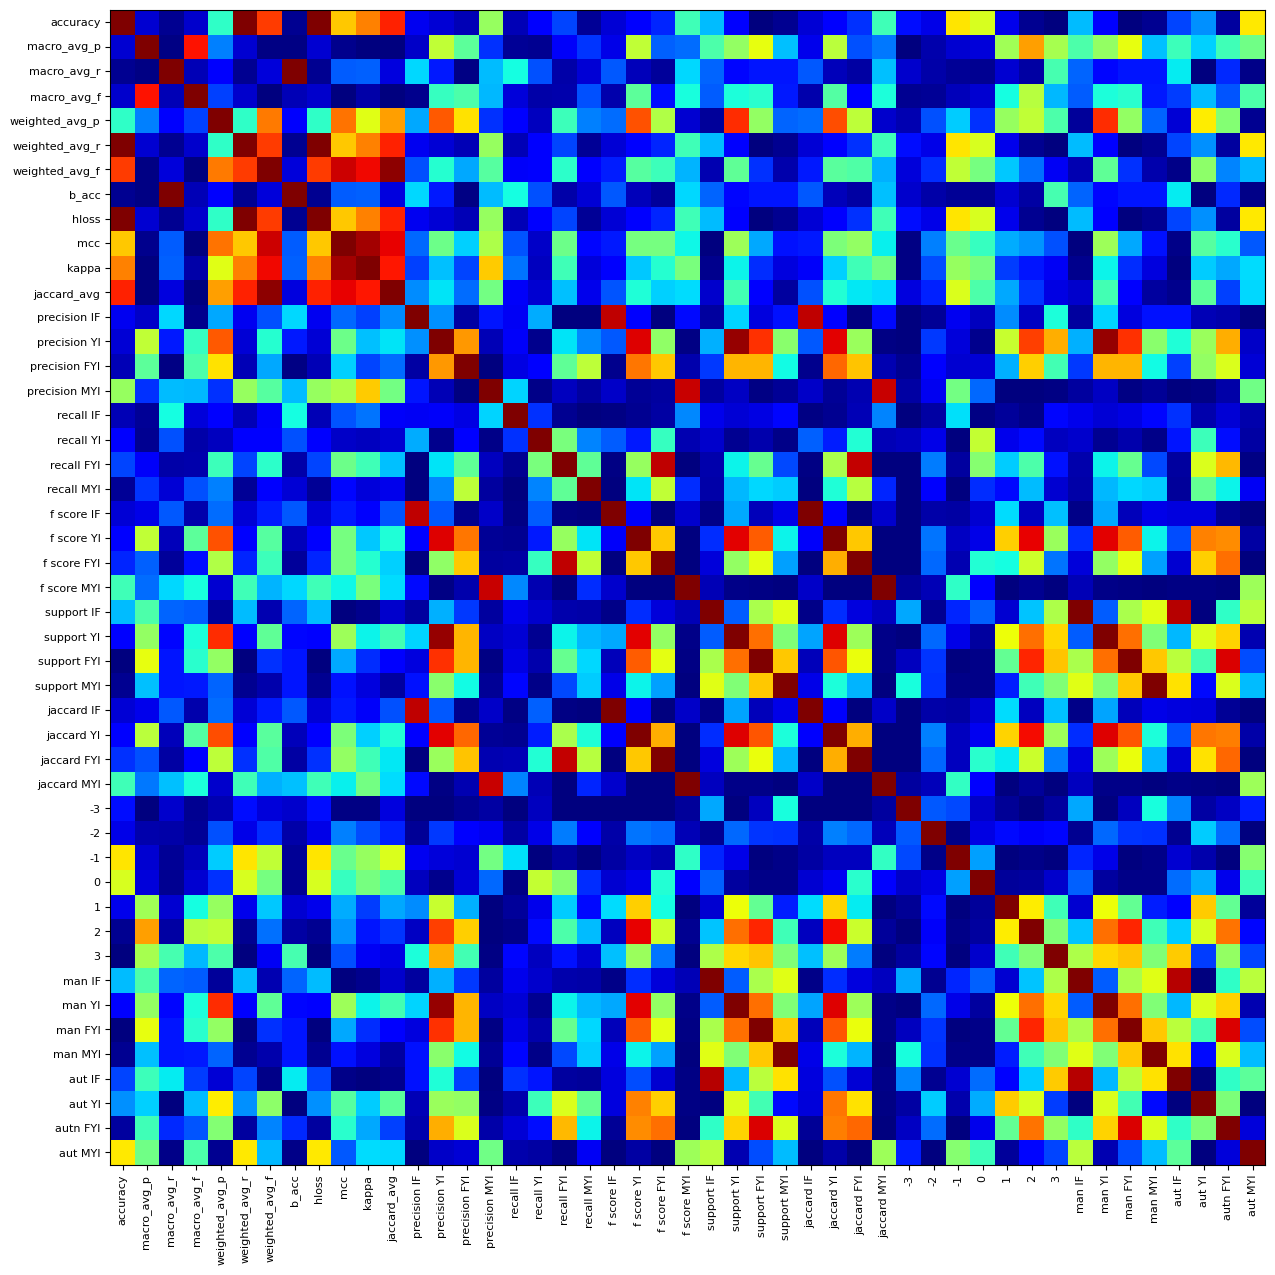

<Figure size 800x700 with 0 Axes>

In [4]:


# Display
plt.figure(figsize=(15,15))
#cmap = plt.cm.get_cmap('bwr')
#cf = cmap(cf)
plt.imshow(cf**2, clim=[0, 1], cmap='jet')

metrics = ["accuracy", "macro_avg_p", "macro_avg_r", "macro_avg_f", "weighted_avg_p", "weighted_avg_r", "weighted_avg_f",
         "b_acc", "hloss", "mcc",
         "kappa", "jaccard_avg", "precision IF", "precision YI", "precision FYI", "precision MYI", "recall IF", "recall YI",
         "recall FYI", "recall MYI", "f score IF", "f score YI", "f score FYI", "f score MYI", "support IF", "support YI",
         "support FYI", "support MYI", "jaccard IF", "jaccard YI", "jaccard FYI", "jaccard MYI", "-3", "-2", "-1", "0", "1",
         "2", "3", "man IF", "man YI", "man FYI", "man MYI", "aut IF", "aut YI", "autn FYI", "aut MYI"]

# Show all ticks and label them with the respective list entries
plt.xticks(np.arange(len(metrics)), metrics)
plt.xticks(rotation=90)
plt.xticks(fontsize=8)

plt.yticks(np.arange(len(metrics)), metrics)
plt.yticks(fontsize=8)

fig = plt.figure(figsize=(8, 7))
# Rotate the tick labels and set their alignment.

plt.show()

matrix of correlation of retained global metrics

(7, 9)


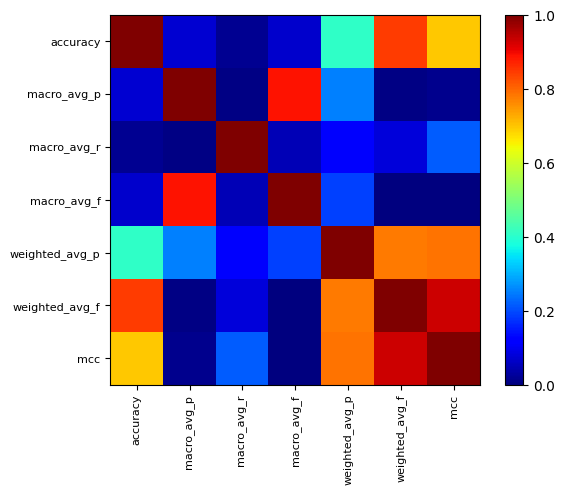

In [5]:
matrix_g = matrix[:12]

for i in reversed ([5, 7, 8, 10, 11]):
    matrix_g = np.delete(matrix_g, i, axis=0)
    
print(matrix_g.shape)

cf_g = np.corrcoef(matrix_g)

plt.imshow(cf_g**2, clim=[0, 1], cmap='jet')
plt.colorbar()

metrics = ["accuracy", "macro_avg_p", "macro_avg_r", "macro_avg_f", "weighted_avg_p", "weighted_avg_f", "mcc"]

# Show all ticks and label them with the respective list entries
plt.xticks(np.arange(len(metrics)), metrics)
plt.xticks(rotation=90)
plt.xticks(fontsize=8)

plt.yticks(np.arange(len(metrics)), metrics)
plt.yticks(fontsize=8)

plt.show()

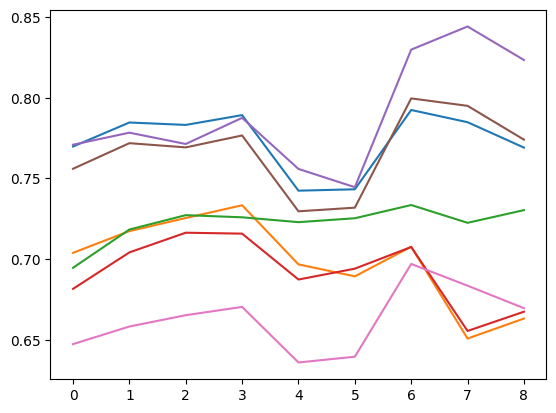

In [6]:
for i in range(7):
    plt.plot(matrix_g[i])
    #plt.xlim([30, 59])

### Compute numbers and percentages

In [7]:
miss = []
miss_b = []
miss_r = []
total = []
for i in range (len(matrix[0])):
    tt = matrix[39][i]+matrix[40][i]+matrix[41][i]+matrix[42][i]
    miss.append(matrix[32][i]+matrix[33][i]+matrix[34][i]+matrix[36][i]+matrix[37][i]+matrix[38][i])
    miss_b.append(matrix[32][i]+matrix[33][i]+matrix[34][i])
    miss_r.append(matrix[36][i]+matrix[37][i]+matrix[38][i])
    total.append(tt)
    
total = np.array(total)
miss = np.array(miss)
miss_r = np.array(miss_r)
miss_b = np.array(miss_b)

In [8]:
# Number of auto px
a1 = matrix[43]/total
a2 = matrix[44]/total
a3 = matrix[45]/total
a4 = matrix[46]/total

# Number of man px
m1 = matrix[39]/total
m2 = matrix[40]/total
m3 = matrix[41]/total
m4 = matrix[42]/total

nb = (np.array(matrix[39]>0).astype('int8') + np.array(matrix[40]>0).astype('int8')+
     np.array(matrix[41]>0).astype('int8')+np.array(matrix[42]>0).astype('int8'))/4

In [9]:
matrix_i = matrix_g

for k in ([a1, a2, a3, a4, m1, m2, m3, m4]):
    matrix_i = np.vstack((matrix_i, k))

matrix_i = np.vstack((matrix_i, total))
matrix_i = np.vstack((matrix_i, miss))
matrix_i = np.vstack((matrix_i, miss_b))
matrix_i = np.vstack((matrix_i, miss_r))

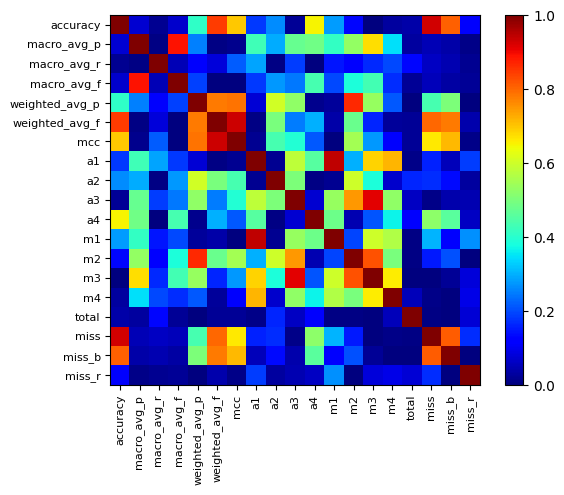

In [10]:
cf_i = np.corrcoef(matrix_i)

plt.imshow(cf_i**2, clim=[0, 1], cmap='jet')
plt.colorbar()

metrics = ["accuracy", "macro_avg_p", "macro_avg_r", "macro_avg_f", "weighted_avg_p", "weighted_avg_f", "mcc", "a1", "a2",
          "a3", "a4", "m1", "m2", "m3", "m4", "total", "miss", "miss_b", "miss_r"]

# Show all ticks and label them with the respective list entries
plt.xticks(np.arange(len(metrics)), metrics)
plt.xticks(rotation=90)
plt.xticks(fontsize=8)

plt.yticks(np.arange(len(metrics)), metrics)
plt.yticks(fontsize=8)

plt.show()

### Plot

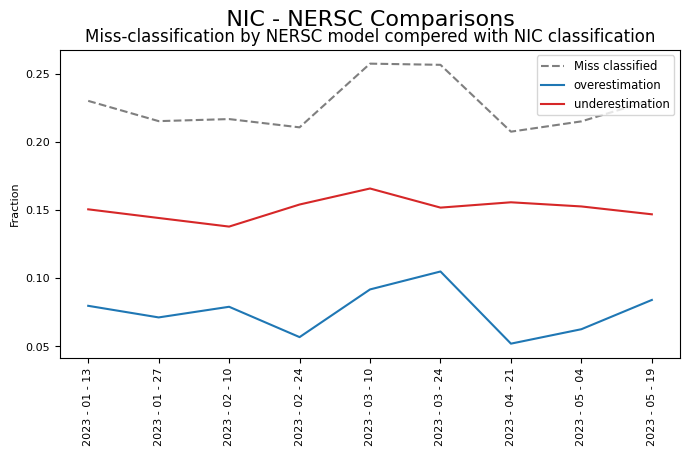

In [11]:
# Display
fig = plt.figure(figsize=(8, 4))
fig.suptitle('   NIC - NERSC Comparisons', fontsize=16)

plt.title('Miss-classification by NERSC model compered with NIC classification')

plt.plot(matrix_i[16]/total, '--', color='tab:gray', label='Miss classified')
plt.plot(matrix_i[17]/total, color='tab:blue', label='overestimation')
plt.plot(matrix_i[18]/total, color='tab:red', label='underestimation')

plt.xticks(np.arange(0, len(day_p)), labels=day_p, rotation='vertical', fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('Fraction', fontsize=8)

plt.legend(loc=1, fontsize='small')

### Metrics per label 

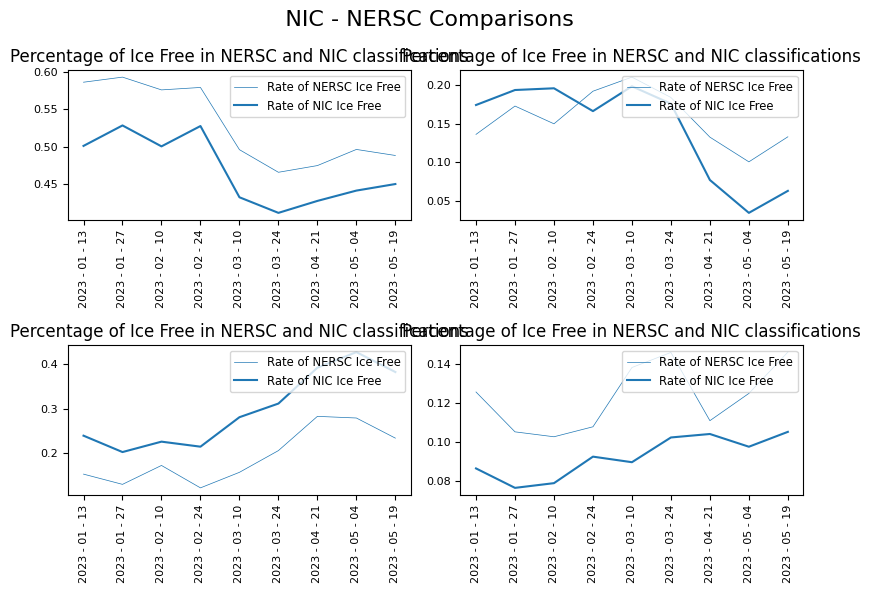

In [12]:
# Display
fig = plt.figure(figsize=(8, 6))
fig.suptitle('   NIC - NERSC Comparisons', fontsize=16)

########
plt.subplot(221)
plt.plot(a1, color='tab:blue', linewidth=0.5,label='Rate of NERSC Ice Free')
plt.plot(m1, label='Rate of NIC Ice Free')
plt.title('Percentage of Ice Free in NERSC and NIC classifications')
#plt.xlim([30,57])
plt.xticks(np.arange(0, len(day_p)), labels=day_p, rotation='vertical', fontsize=8)
plt.yticks(fontsize=8)

plt.legend(fontsize='small', loc=1)

########
plt.subplot(222)
plt.plot(a2, color='tab:blue', linewidth=0.5,label='Rate of NERSC Ice Free')
plt.plot(m2, label='Rate of NIC Ice Free')
plt.title('Percentage of Ice Free in NERSC and NIC classifications')
#plt.xlim([30,57])
plt.xticks(np.arange(0, len(day_p)), labels=day_p, rotation='vertical', fontsize=8)
plt.yticks(fontsize=8)

plt.legend(fontsize='small', loc=1)

########
plt.subplot(223)
plt.plot(a3, color='tab:blue', linewidth=0.5,label='Rate of NERSC Ice Free')
plt.plot(m3, label='Rate of NIC Ice Free')
plt.title('Percentage of Ice Free in NERSC and NIC classifications')
#plt.xlim([30,57])
plt.xticks(np.arange(0, len(day_p)), labels=day_p, rotation='vertical', fontsize=8)
plt.yticks(fontsize=8)

plt.legend(fontsize='small', loc=1)

########
plt.subplot(224)
plt.plot(a4, color='tab:blue', linewidth=0.5,label='Rate of NERSC Ice Free')
plt.plot(m4, label='Rate of NIC Ice Free')
plt.title('Percentage of Ice Free in NERSC and NIC classifications')
#plt.xlim([30,57])
plt.xticks(np.arange(0, len(day_p)), labels=day_p, rotation='vertical', fontsize=8)
plt.yticks(fontsize=8)

#plt.text(1,0.43, "Correlation ≈ -0.97", size=12, ha="center", va="center")
#plt.text(1,0.42, "(Corrélation YI and Accuracy ≈ -0.80)", size=6, ha="center", va="center")

plt.legend(fontsize='small', loc=1)

#fig.subplots_adjust(hspace=0.2)
fig.tight_layout()

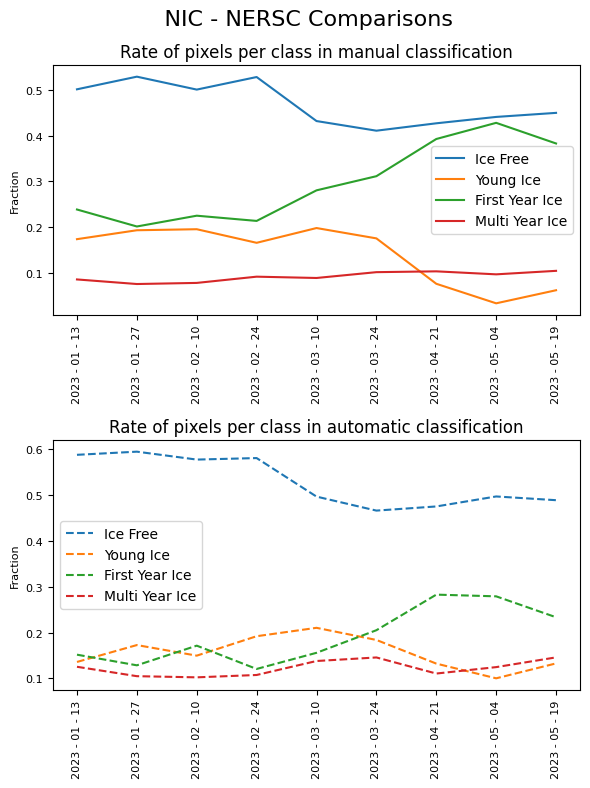

In [13]:
# Display
fig = plt.figure(figsize=(6, 8))
fig.suptitle('    NIC - NERSC Comparisons', fontsize=16)

####
plt.subplot(211)
plt.plot(m1, color='tab:blue', label='Ice Free')
plt.plot(m2, color='tab:orange', label='Young Ice')
plt.plot(m3, color='tab:green', label='First Year Ice')
plt.plot(m4, color='tab:red', label='Multi Year Ice')
plt.title('Rate of pixels per class in manual classification')
plt.xticks(np.arange(0, len(day_p)), labels=day_p, rotation='vertical', fontsize=8)
plt.yticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('Fraction', fontsize=8)

plt.legend()

####
plt.subplot(212)
plt.plot(a1, '--',color='tab:blue', label='Ice Free')
plt.plot(a2, '--',color='tab:orange', label='Young Ice')
plt.plot(a3, '--',color='tab:green', label='First Year Ice')
plt.plot(a4, '--',color='tab:red', label='Multi Year Ice')
plt.title('Rate of pixels per class in automatic classification')
plt.xticks(np.arange(0, len(day_p)), labels=day_p, rotation='vertical', fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('Fraction', fontsize=8)

plt.legend()

#fig.subplots_adjust(hspace=0.2)
fig.tight_layout()

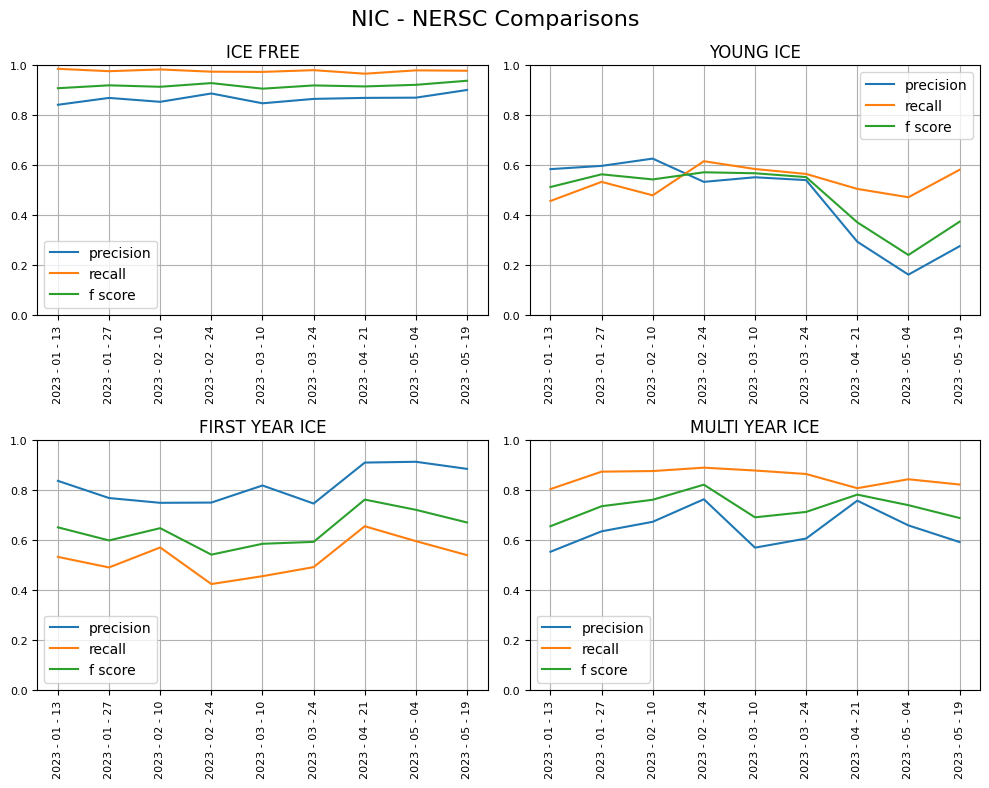

In [14]:
inter = [30,57]
lab = ['precision', 'recall', 'f score']

fig = plt.figure(figsize=(10, 8))
fig.suptitle('NIC - NERSC Comparisons', fontsize=16)

###
plt.subplot(221)
IT = 12
for i in range (3):
    plt.plot(matrix[4*i + IT], label=lab[i])
    plt.xticks(np.arange(0, len(day_p)), labels=day_p, rotation='vertical', fontsize=8)
    plt.yticks(fontsize=8)
    plt.ylim([0,1])
    
plt.legend()
plt.title('ICE FREE')
plt.grid()

###
plt.subplot(222)
IT = 13
for i in range (3):
    plt.plot(matrix[4*i + IT], label=lab[i])
    plt.xticks(np.arange(0, len(day_p)), labels=day_p, rotation='vertical', fontsize=8)
    plt.yticks(fontsize=8)
    plt.ylim([0,1])

plt.legend()
plt.title('YOUNG ICE')
plt.grid()

###
plt.subplot(223)

IT = 14
for i in range (3):
    plt.plot(matrix[4*i + IT], label=lab[i])
    plt.xticks(np.arange(0, len(day_p)), labels=day_p, rotation='vertical', fontsize=8)
    plt.yticks(fontsize=8)
    plt.ylim([0,1])

plt.legend()    
plt.title('FIRST YEAR ICE')
plt.grid()

###
plt.subplot(224)
IT = 15
for i in range (3):
    plt.plot(matrix[4*i + IT], label=lab[i])
    plt.xticks(np.arange(0, len(day_p)), labels=day_p, rotation='vertical', fontsize=8)
    plt.yticks(fontsize=8)
    plt.ylim([0,1])

plt.legend()    
plt.title('MULTI YEAR ICE')
plt.grid()

fig.tight_layout()